# House Prices: Advanced Regression Techniques

<p><a name="sections"></a></p>


## Sections

- <a href="#description">Description</a><br>
- <a href="#executive_summary">Executive Summary</a><br>
- <a href="#data_import">Data Import</a><br>
- <a href="#feature_engineering">Feature Engineering</a><br>
- <a href="#data_cleaning_and_eda">Data Cleaning and EDA</a><br>
- <a href="#models">Models</a><br>
    - <a href="#lasso">Lasso</a><br>
    - <a href="#decision_tree">Decision Tree</a><br>
    - <a href="#bagging">Bagging</a><br>
    - <a href="#random_forest">Random Forest</a><br>
    - <a href="#boosting">Boosting</a><br>
    - <a href="#xgboost">XGBoost</a><br>
- <a href="#submission">Submission</a><br>

<p><a name="description"></a></p>

## Description

<p><a name="executive_summary"></a></p>

## Executive Summary

<p><a name="data_import_and_cleaning"></a></p>

## Data Import and Cleaning

**import libaries**

In [429]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from feature_selection import VarianceReduction
from sklearn.metrics import mean_squared_log_error

**read training data**

In [421]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**remove column id, target = log(1+Sales_Price)**

In [422]:
# set column Id as index
train.drop(['Id'],axis=1,inplace=True)
# set log of SalePrice as target column
target = np.log1p(1+train['SalePrice'])
# remove SalePrice from training data
train = train.iloc[:,:-1]
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**display percentage of NAs**

In [423]:
temp = train.isnull().any()
cols_na = temp[temp==True].index.tolist()
train_na = train.loc[:,cols_na].isnull().astype(int).mean().sort_values(ascending=False)
train_na

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

<p><a name="feature_engineering"></a></p>

## Feature Engineering

**total square footage**

0.7371302277161353


Text(0, 0.5, 'log(Sales Price)')

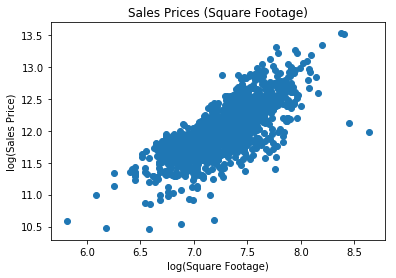

In [424]:
train['FlrSF'] = train['1stFlrSF']+train['2ndFlrSF']
# remove 1stFlrSF
train.drop(['1stFlrSF'],axis=1,inplace=True)
print(np.log(train['FlrSF']).corr(target))
plt.scatter(np.log(train['FlrSF']), target, marker='o')
plt.title("Sales Prices (Square Footage)")
plt.xlabel("log(Square Footage)")
plt.ylabel("log(Sales Price)")

**neighborhood**

Sales Price Variance Explained by Neighbourhood: 0.57079668350165
Average Price: 12.090587529381933
24


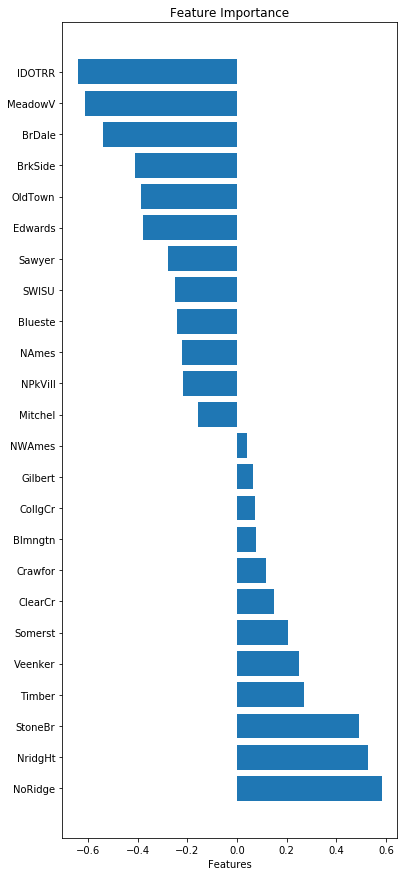

In [416]:
Neighborhood_encoded = pd.get_dummies(data=train['Neighborhood'])
X = (Neighborhood_encoded - Neighborhood_encoded.mean())/Neighborhood_encoded.std()
cols = Neighborhood_encoded.columns.tolist()
reg = lassocv.fit(Neighborhood_encoded,target)
print('Sales Price Variance Explained by Neighbourhood: {}'.format(reg.score(Neighborhood_encoded,target)))
print('Average Price: {}'.format(reg.intercept_))
coefs = pd.Series(reg.coef_.tolist(),index=cols)
coefs = coefs[coefs!=0]
print(len(coefs))
coefs = coefs.sort_values(ascending=False)
objects = coefs.index.tolist()
y_arange = np.arange(len(objects))
values = coefs.tolist()
fig = plt.figure(figsize=(6,15))
plt.barh(y_arange, values, align='center')
plt.yticks(y_arange, objects)
plt.xlabel('Features')
plt.title('Feature Importance')
plt.show()

<p><a name="data_cleaning_and_eda"></a></p>

## Data Cleaning and EDA

**divide training data into numeric and categoric variables**

In [418]:
# numeric data
train_numeric = train._get_numeric_data()
# all columns
cols_all = train.columns.tolist()
# numeric columns
cols_numeric = train_numeric.columns.tolist()
# categoric columns
cols_categoric = list(set(cols_all)-set(cols_numeric))
# categoric data
train_categoric = train.loc[:,cols_categoric]
print('numeric columns: {}'.format(cols_numeric))
print('categoric columns: {}'.format(cols_categoric))
print((train_numeric==0).any())

numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'FlrSF']
categoric columns: ['Alley', 'MiscFeature', 'Functional', 'PoolQC', 'SaleType', 'HouseStyle', 'RoofMatl', 'Foundation', 'ExterCond', 'Exterior2nd', 'LotShape', 'Electrical', 'MasVnrType', 'BsmtQual', 'HeatingQC', 'Condition2', 'BldgType', 'FireplaceQu', 'KitchenQual', 'Street', 'GarageQual', 'GarageCond', 'RoofStyle', 'BsmtCond', 'LotConfig', 'Utilities', 'LandContour', 'CentralAir', 'MSZoning', 'Condition1', 'Exterior1st', 'BsmtFinType2', 'Fence', 'BsmtExposure', 'ExterQual', 'He

**extract and encode NAs from numeric columns into new variables**

In [383]:
# find columns containing at least one NA
cols_numeric_na = train_numeric.columns[train_numeric.isnull().any()].tolist()
# create new variables that encode NAs in numeric variables
train_numeric_na = train_numeric.loc[:,cols_numeric_na].isnull().astype(int)
# add suffix Absent to column names
train_numeric_na.columns = list(map(lambda x: x + '_Absent',cols_numeric_na))
train_numeric_na.head()

,LotFrontage_Absent,MasVnrArea_Absent,GarageYrBlt_Absent
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


**impute NAs in numeric variables**

In [384]:
# fill NA by value 0 (Lot Frontage is absent)
train_numeric['LotFrontage'].fillna(value = train_numeric['LotFrontage'].mean(),inplace=True)
# fill NA by value 0 (MasVnrArea is absent)
train_numeric['MasVnrArea'].fillna(value = train_numeric['MasVnrArea'].mean(),inplace=True)
# fill NA by value 0 (MasVnrArea is absent)
train_numeric['GarageYrBlt'].fillna(value = train_numeric['GarageYrBlt'].mean(),inplace=True )

In [386]:
# encode categoric variables
train_categoric_encoded = pd.get_dummies(data = train_categoric,dummy_na = True)#dummy_na = True,drop_first=True ,dummy_na = True
# drop columns with all zeros
train_categoric_encoded = train_categoric_encoded.loc[:, (train_categoric_encoded != 0).any(axis=0)]
cols_categoric_encoded = train_categoric_encoded.columns.tolist()
train_categoric_encoded.head()

,Alley_Grvl,Alley_Pave,Alley_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,Functional_Maj1,Functional_Maj2,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [387]:
# combine numeric columns, encoded categoric columns, encoded NAs in numeric columns
X = pd.concat([train_categoric_encoded,train_numeric,train_numeric_na],axis=1)
# save target in series y
y = target
cols = X.columns.tolist()
X.head()

,Alley_Grvl,Alley_Pave,Alley_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,Functional_Maj1,Functional_Maj2,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,FlrSF,LotFrontage_Absent,MasVnrArea_Absent,GarageYrBlt_Absent
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,2,2008,7.444249,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,5,2007,7.140453,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,9,2008,7.487734,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,2,2006,7.448334,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,12,2008,7.695303,0,0,0


**standardize all variables**

In [389]:
X = (X - X.mean())/X.std()
X.head()

,Alley_Grvl,Alley_Pave,Alley_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,Functional_Maj1,Functional_Maj2,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,FlrSF,LotFrontage_Absent,MasVnrArea_Absent,GarageYrBlt_Absent
0,-0.188246,-0.169923,0.257733,-0.037024,-0.037024,-0.186288,-0.026171,0.195909,-0.098363,-0.058601,...,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,0.138730,0.539923,-0.464226,-0.074202,-0.242277
1,-0.188246,-0.169923,0.257733,-0.037024,-0.037024,-0.186288,-0.026171,0.195909,-0.098363,-0.058601,...,-0.116299,-0.270116,-0.068668,-0.087658,-0.488943,-0.614228,-0.370021,-0.464226,-0.074202,-0.242277
2,-0.188246,-0.169923,0.257733,-0.037024,-0.037024,-0.186288,-0.026171,0.195909,-0.098363,-0.058601,...,-0.116299,-0.270116,-0.068668,-0.087658,0.990552,0.138730,0.670171,-0.464226,-0.074202,-0.242277
3,-0.188246,-0.169923,0.257733,-0.037024,-0.037024,-0.186288,-0.026171,0.195909,-0.098363,-0.058601,...,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,-1.367186,0.552159,-0.464226,-0.074202,-0.242277
4,-0.188246,-0.169923,0.257733,-0.037024,-0.037024,-0.186288,-0.026171,0.195909,-0.098363,-0.058601,...,-0.116299,-0.270116,-0.068668,-0.087658,2.100173,0.138730,1.291894,-0.464226,-0.074202,-0.242277


<p><a name="models"></a></p>   

## Models 

<p><a name="lasso"></a></p>

## Models: Lasso

In [ ]:
lassocv = LassoCV(cv=10,n_alphas=1000)

In [391]:
reg = lassocv.fit(X,y)

No handles with labels found to put in legend.


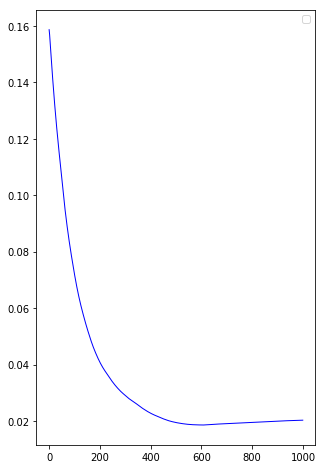

In [392]:
#reg.alphas_
mse_path = np.mean(reg.mse_path_,axis=1)
fig = plt.figure(figsize=(5,8))
plt.plot(mse_path,color='blue',linewidth=1)
#plt.plot(df_y['y_estimated'].tolist(),color='black',linewidth=0.1)
plt.legend()
plt.show()

In [393]:
reg.score(X,y)

0.9308627007456531

In [394]:
coefs = pd.Series(reg.coef_.tolist(),index=cols)
coefs = coefs[coefs!=0]
print(len(coefs))
coefs = coefs.sort_values(ascending=False)
coefs_pos = coefs[coefs>0].sort_values(ascending=False)
coefs_pos = coefs[coefs<0].sort_values()

93


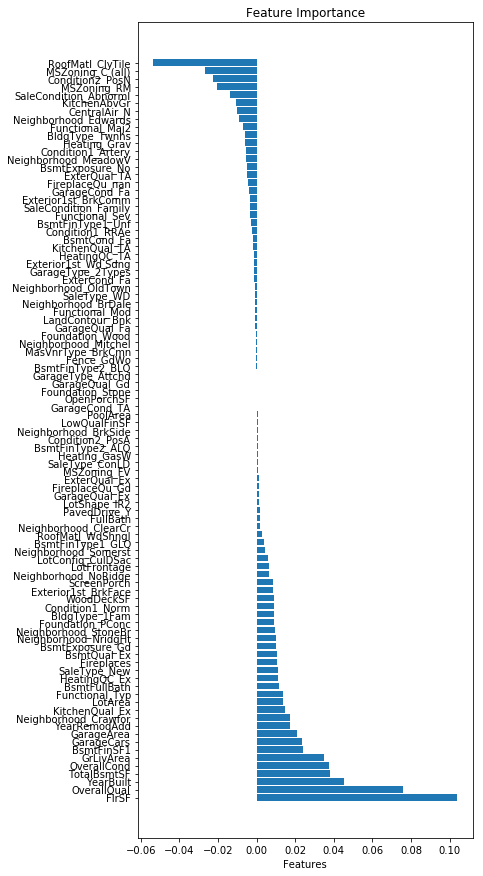

In [395]:
objects = coefs.index.tolist()
y_arange = np.arange(len(objects))
values = coefs.tolist()
fig = plt.figure(figsize=(6,15))
plt.barh(y_arange, values, align='center')
plt.yticks(y_arange, objects)
plt.xlabel('Features')
plt.title('Feature Importance')
plt.show()

In [396]:
# intercept is an average of sale prices
reg.intercept_

12.024050901109383

**estimate sale prices**

In [397]:
y_estimated = lassocv.predict(X)
df_y = pd.DataFrame({'y':y,'y_estimated':y_estimated}).sort_values('y')
df_y.head()

,y,y_estimated
495,10.460242,10.901015
916,10.471950,10.681229
968,10.542706,11.111149
533,10.578980,10.747963
30,10.596635,11.154262


**plot actual and estimated sale prices**

No handles with labels found to put in legend.


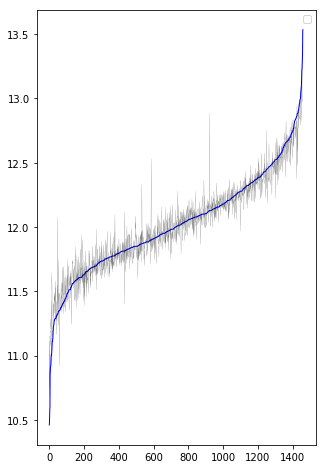

In [398]:
fig = plt.figure(figsize=(5,8))
plt.plot(df_y['y'].tolist(),color='blue',linewidth=1)
plt.plot(df_y['y_estimated'].tolist(),color='black',linewidth=0.1)
plt.legend()
plt.show()

**lasso testing rate with 10-fold cross-validation**

In [425]:
repeatedkfold = RepeatedKFold()
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2652124)
sample = range(0,X.shape[0])
train_score = []
test_score = []
y_train_lst = []
y_train_estimated_lst = []
y_test_lst = []
y_test_estimated_lst = []
iteration = 1
for train_index, test_index in rkf.split(sample):
    print('iteration {}'.format(iteration))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = lassocv.fit(X_train,y_train)
    train_score.append(reg.score(X_train,y_train))
    test_score.append(reg.score(X_test,y_test))
    y_train_lst += y_train.tolist()
    y_test_lst += y_test.tolist()
    y_train_estimated_lst += lassocv.predict(X_train).tolist()
    y_test_estimated_lst += lassocv.predict(X_test).tolist()
    iteration += 1
print('train_score={}'.format(train_score))
print('test_score={}'.format(test_score))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
train_score=[0.5742533597186104, 0.5745008586443241, 0.5690961535114153, 0.5826615792468046, 0.5809400628094943, 0.5647150930755185, 0.5792906787954041, 0.5672403889646616, 0.5646563830024827, 0.5587290426830893, 0.5715567977174193, 0.568021939707378, 0.5698211988833084, 0.5726761770864042, 0.5761680654008641, 0.5757997552189271, 0.5644114620497618, 0.57717

In [402]:
print('mean train_score: {}'.format(np.mean(np.array(train_score))))
print('std train_score: {}'.format(np.std(np.array(train_score))))
print('mean test_score: {}'.format(np.mean(np.array(test_score))))
print('std test_score: {}'.format(np.std(np.array(test_score))))
print('train root_mean_squared_log_error: {}'.\
      format(np.sqrt(mean_squared_log_error(np.exp(y_train_lst),np.exp(y_train_estimated_lst)))))
print('train root_mean_squared_log_error: {}'.\
      format(np.sqrt(mean_squared_log_error(np.exp(y_test_lst),np.exp(y_test_estimated_lst)))))

mean train_score: 0.9314280757551732
std train_score: 0.004322609578454679
mean test_score: 0.8771357905485718
std test_score: 0.07686053493244988
train root_mean_squared_log_error: 0.10456298412238473
train root_mean_squared_log_error: 0.14025484751275769


In [306]:
df_y = pd.DataFrame({'y':y_test_lst,'y_estimated':y_test_estimated_lst}).sort_values('y')
df_y.head()

,y,y_estimated
58,10.460242,11.034970
819,10.471950,10.913311
525,10.542706,11.196262
935,10.578980,10.945361
733,10.596635,11.294520


**10-fold cross validation: plot actual and estimated test price**

No handles with labels found to put in legend.


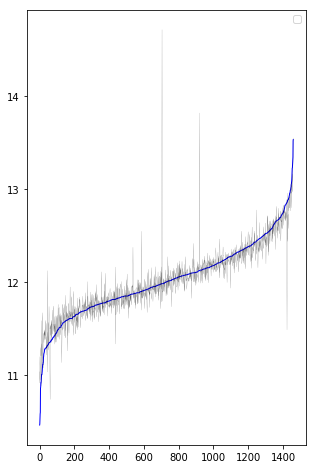

In [307]:
fig = plt.figure(figsize=(5,8))
plt.plot(df_y['y'].tolist(),color='blue',linewidth=1)
plt.plot(df_y['y_estimated'].tolist(),color='black',linewidth=0.1)
plt.legend()
plt.show()

<p><a name="submission"></a></p>

## Submission

In [105]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [106]:
temp = test.isnull().any()
cols_na = temp[temp==True].index.tolist()
train_na = train.loc[:,cols_na].isnull().astype(int).mean().sort_values(ascending=False)
train_na

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
GarageType      0.055479
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtQual        0.025342
BsmtCond        0.025342
MasVnrType      0.005479
Exterior1st     0.000000
Exterior2nd     0.000000
MasVnrArea      0.000000
Utilities       0.000000
LotFrontage     0.000000
SaleType        0.000000
TotalBsmtSF     0.000000
BsmtFinSF1      0.000000
BsmtFinSF2      0.000000
BsmtUnfSF       0.000000
BsmtFullBath    0.000000
BsmtHalfBath    0.000000
KitchenQual     0.000000
Functional      0.000000
GarageYrBlt     0.000000
GarageCars      0.000000
GarageArea      0.000000
MSZoning        0.000000
dtype: float64

In [107]:
# numeric data
test_numeric = test._get_numeric_data()
# all columns
cols_all = test.columns.tolist()
# numeric columns
cols_numeric = test_numeric.columns.tolist()
# categoric columns
cols_categoric = list(set(cols_all)-set(cols_numeric))
# categoric data
test_categoric = test.loc[:,cols_categoric]
test_categoric.head()

,Alley,MiscFeature,Functional,PoolQC,SaleType,HouseStyle,RoofMatl,Foundation,ExterCond,Exterior2nd,...,BsmtExposure,ExterQual,Heating,GarageFinish,LandSlope,BsmtFinType1,PavedDrive,SaleCondition,GarageType,Neighborhood
0,NaN,NaN,Typ,NaN,WD,1Story,CompShg,CBlock,TA,VinylSd,...,No,TA,GasA,Unf,Gtl,Rec,Y,Normal,Attchd,NAmes
1,NaN,Gar2,Typ,NaN,WD,1Story,CompShg,CBlock,TA,Wd Sdng,...,No,TA,GasA,Unf,Gtl,ALQ,Y,Normal,Attchd,NAmes
2,NaN,NaN,Typ,NaN,WD,2Story,CompShg,PConc,TA,VinylSd,...,No,TA,GasA,Fin,Gtl,GLQ,Y,Normal,Attchd,Gilbert
3,NaN,NaN,Typ,NaN,WD,2Story,CompShg,PConc,TA,VinylSd,...,No,TA,GasA,Fin,Gtl,GLQ,Y,Normal,Attchd,Gilbert
4,NaN,NaN,Typ,NaN,WD,1Story,CompShg,PConc,TA,HdBoard,...,No,Gd,GasA,RFn,Gtl,ALQ,Y,Normal,Attchd,StoneBr


In [108]:
# find columns containing at least one NA
cols_numeric_na = train_numeric.columns[train_numeric.isnull().any()].tolist()
# create new variables that encode NAs in numeric variables
train_numeric_na = train_numeric.loc[:,cols_numeric_na].isnull().astype(int)
# add suffix Absent to column names
train_numeric_na.columns = list(map(lambda x: x + '_Absent',cols_numeric_na))
train_numeric_na.head()

""
0
1
2
3
4
